# A Systematic Application of Machine Learning to Stellar Classification

Install and import required dependencies

In [ ]:
!pip install numpy
!pip install torch
!pip install scikit-learn
!pip install matplotlib
!pip install mlxtend
!pip install seaborn

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.utils.data as data_utils

## Exploring the Data

Encoder utilized to convert string labels to an integer

In [3]:
# Encodes string labels to an integer (0, 1, 2)
def Encoder(df):
    encodeColumns = list(df.select_dtypes(include=['category','object']))
    labelEncoder = LabelEncoder()
    for column in encodeColumns:
      df[column] = labelEncoder.fit_transform(df[column])

    return df

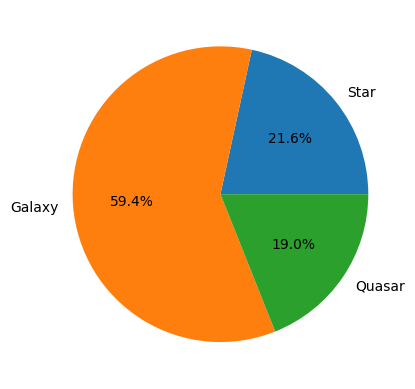

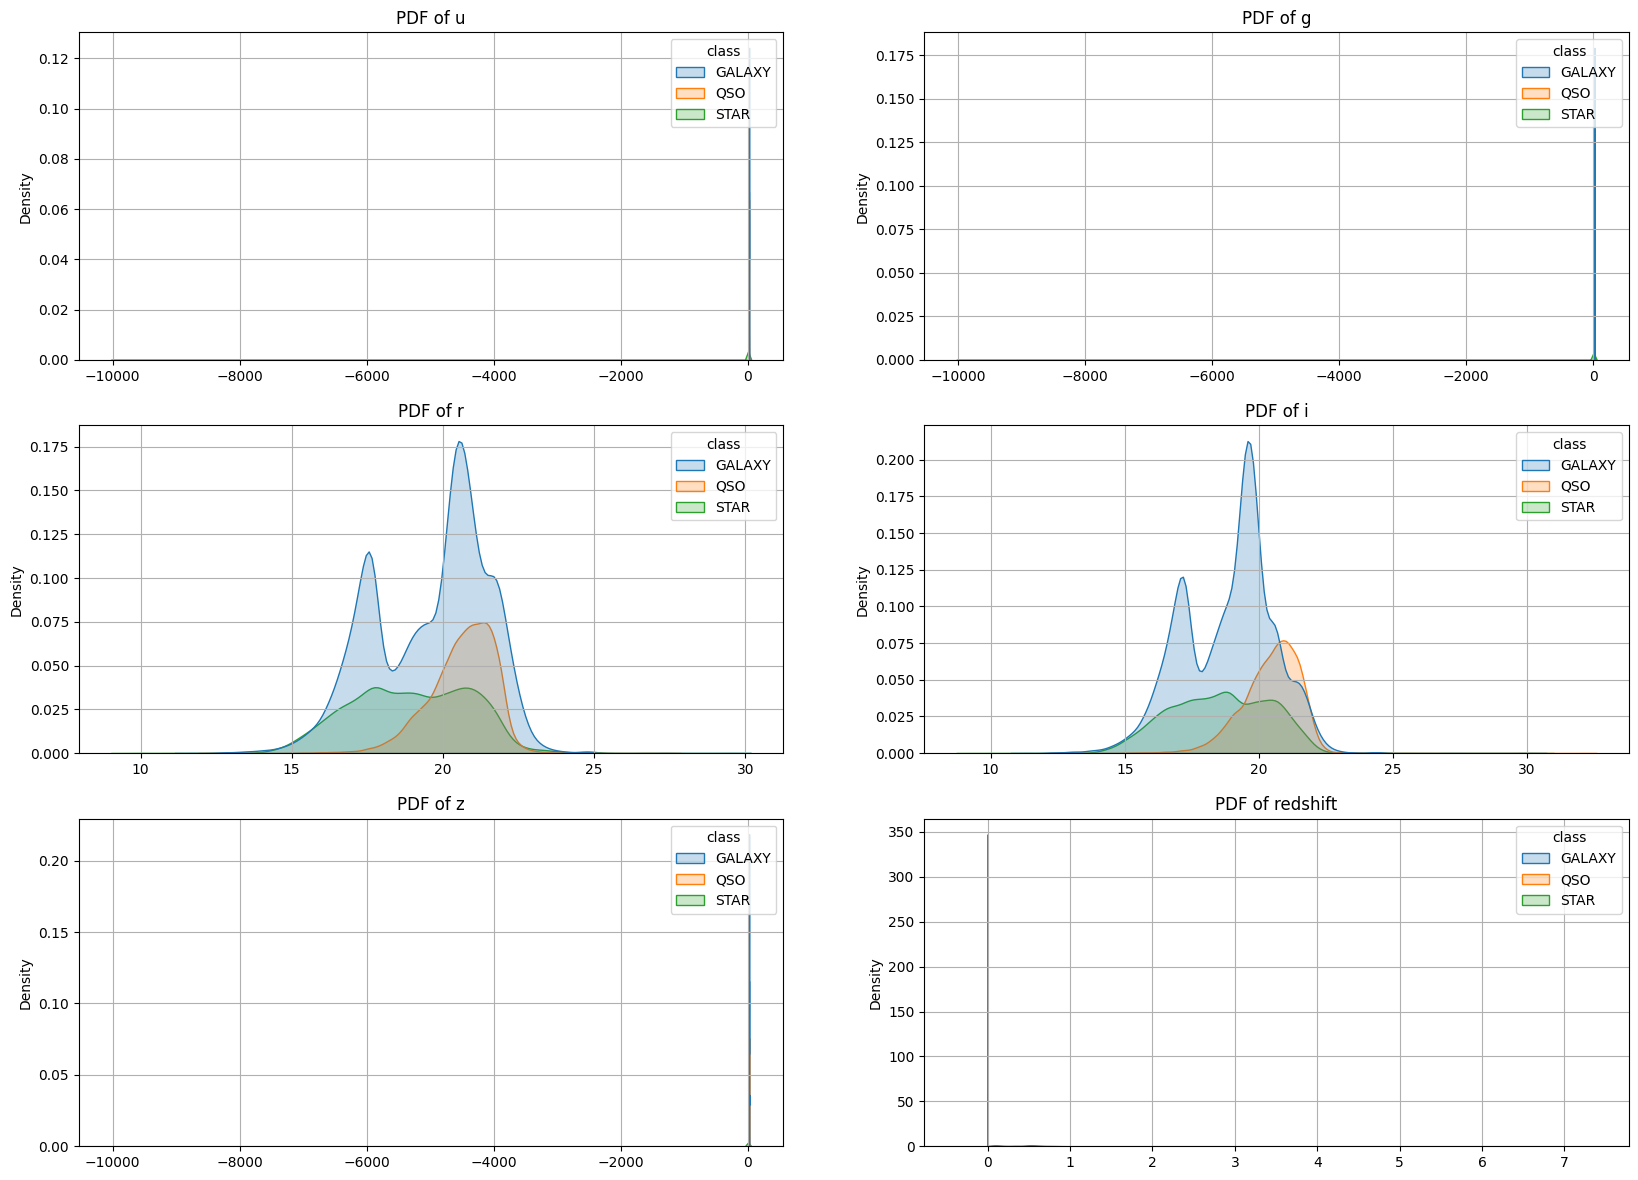

In [16]:
# Read data into program
path = "star_classification.csv"
raw_data = pd.read_csv(path)

# Process data for exploration
star = raw_data.loc[raw_data['class'] == "STAR"]      # Stores rows where label is star
galaxy = raw_data.loc[raw_data['class'] == "GALAXY"]  # Stores rows where label is galaxy
quasar = raw_data.loc[raw_data['class'] == "QSO"]     # Stores rows where label is quasar

labels = 'Star', 'Galaxy', 'Quasar'
sizes = [len(star), len(galaxy), len(quasar)]

# Plot pie chart showing proportions of classes
fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%')

# Plot probability distribution functions for each feature
feats = ['u', 'g', 'r', 'i', 'z', 'redshift']
plt.figure(figsize=(20, 40))
for (i, feat) in enumerate(feats):
    plt.subplot(int('82'+ str(i+1)))
    sns.kdeplot(data=raw_data, x=feat, hue='class', fill=True)
    plt.title(label=f'PDF of {feat}')
    plt.xlabel(xlabel='')
    plt.grid()
    i += 1
plt.show()

## Classification with multi-class SVMs

In [ ]:
from sklearn import svm, datasets
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.multiclass import OneVsRestClassifier
from mlxtend.plotting import plot_decision_regions

# Process data and split into training and testing set
path = "star_classification.csv"
raw_data = pd.read_csv(path)

# Transform raw data to utilize only the features we need
temp = Encoder(raw_data).to_numpy()
labels = temp[:,13]
features = np.delete(temp, 13, axis=1)
features = np.delete(temp, [0,1,2,8,9,10,11,12,13,15,16,17], axis=1)

X_train, X_test, y_train, y_test = train_test_split(features, labels, stratify=labels, test_size=0.30, random_state=42)

# Lists for acuracies to store between each experiment
ovo_train_accuracies = []
ovo_test_accuracies = []
ovr_train_accuracies = []
ovr_test_accuracies = []
ovo_best_accuracy = 0
ovr_best_accuracy = 0
C = np.array([1] + [i for i in range(20, 101, 20)])

# Iterate over each entry in array for the regularization parameter C
for i in C:
    # Classify dataset using ovo SVM for train and test set
    ovo = svm.SVC(C=i, decision_function_shape='ovo',random_state=42).fit(X_train, y_train)
    ovo_y_pred_train = ovo.predict(X_train)
    ovo_y_pred_test = ovo.predict(X_test)

    # Store ovo accuracies
    ovo_train_accuracy = accuracy_score(y_train, ovo_y_pred_train)
    ovo_test_accuracy = accuracy_score(y_test, ovo_y_pred_test)
    ovo_test_accuracies.append(ovo_test_accuracy)
    ovo_train_accuracies.append(ovo_train_accuracy)

    # Classify dataset using ovr SVM for train and test set
    ovr = OneVsRestClassifier(svm.SVC(C=i, random_state=42)).fit(X_train, y_train)
    ovr_y_pred_train = ovr.predict(X_train)
    ovr_y_pred_test = ovr.predict(X_test)

    # Store ovr accuracies
    ovr_train_accuracy = accuracy_score(y_train, ovr_y_pred_train)
    ovr_test_accuracy = accuracy_score(y_test, ovr_y_pred_test)
    ovr_test_accuracies.append(ovr_test_accuracy)
    ovr_train_accuracies.append(ovr_train_accuracy)

    # Check for best accuracy in ovo and ovr SVMs
    if ovo_test_accuracy > ovo_best_accuracy:
        ovo_best_accuracy = ovo_test_accuracy

    if ovr_test_accuracy > ovr_best_accuracy:
        ovr_best_accuracy = ovr_test_accuracy

print(f'Best ovo accuracy: {ovo_best_accuracy}')
print(f'Best ovr accuracy: {ovr_best_accuracy}')

ovo_train_accuracies = np.array(ovo_train_accuracies)
ovo_test_accuracies = np.array(ovo_test_accuracies)
ovr_train_accuracies = np.array(ovr_train_accuracies)
ovr_test_accuracies = np.array(ovr_test_accuracies)

print(f'Regularization parameters tested: {C}')
print(f'Test accuracies for ovo: {ovo_test_accuracies}')
print(f'Test accuracies for ovo: {ovr_test_accuracies}')

# Plot training accuracies for ovo and ovr
plt.plot(C, ovo_train_accuracies, label="ovo")
plt.plot(C, ovr_train_accuracies, label="ovr")
plt.legend()
plt.xlabel('Regularization Parameter')
plt.ylabel('Train Accuracy')
plt.title("Train Accuracy vs Regularization Parameter")
plt.show()

# Plot testing accuracies for ovo and ovr
plt.plot(C, ovo_test_accuracies, label="ovo")
plt.plot(C, ovr_test_accuracies, label="ovr")
plt.legend()
plt.xlabel('Regularization Parameter')
plt.ylabel('Test Accuracy')
plt.title("Test Accuracy vs Regularization Parameter")
plt.show()


## Classification with Neural Network

Preparing data for input in neural network

In [ ]:
# Load data
path = "star_classification.csv"
raw_data = pd.read_csv(path).to_numpy()

# Transform data with one-hot encoding for labels
labels = raw_data[:,13]
labels = labels[:, None]
ohe = OneHotEncoder(handle_unknown='ignore').fit(labels)
labels = ohe.transform(labels).toarray()

# Extract important features
features = np.delete(raw_data, 13, axis=1)
features = np.delete(raw_data, [0,1,2,8,9,10,11,12,13,15,16,17], axis=1)
features = np.asfarray(features)

X_train, X_test, y_train, y_test = train_test_split(features, labels, stratify=labels, test_size=0.30, random_state=42)

# Convert data into tensors for pytorch
X = torch.tensor(X_train, dtype=torch.float32)
Y = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
Y_test = torch.tensor(y_test, dtype=torch.float32)

# Create train and test loaders
train_data = data_utils.TensorDataset(X, Y)
train_loader = data_utils.DataLoader(train_data, batch_size=50, shuffle=True)

test_data = data_utils.TensorDataset(X_test, Y_test)
test_loader = data_utils.DataLoader(test_data, batch_size=50, shuffle=False)

Implementation of neural network model

In [ ]:
class NeuralNet(nn.Module):
    def __init__(self, num_layers, hidden_dim):
        super().__init__()

        self.layers = []

        # Generate layers with specified number of layers and nodes
        for i in range(num_layers):
            if i == 0:
                self.layers.append(nn.Linear(6, hidden_dim))
                self.layers.append(nn.ReLU())
            elif i == num_layers-1:
                self.layers.append(nn.Linear(hidden_dim, 3))
            else:
                self.layers.append(nn.Linear(hidden_dim, hidden_dim))
                self.layers.append(nn.ReLU())

        self.net = nn.Sequential(*self.layers)

    def forward(self, x):
        x = self.net(x)
        return x

Definition for training and testing neural network

In [ ]:
# Training function
def train(model, loss_fn, loader):
    model.train()

    # For each sample: predict the label, calculate the loss, and change weights via gradient
    for x, y in train_loader:
        y_pred = model(x)
        loss = loss_fn(y_pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# Testing function
def test(model, loss_fn, loader):
    model.eval()

    # Initialize variables for calculating metrics
    total_loss = 0.0
    total_nodes = 0
    accuracies = []

    with torch.no_grad():
        for x, y in loader:
            # Calculate loss from prediction
            y_pred = model(x)
            loss = loss_fn(y_pred, y)

            # Update total loss and number of nodes for accuracy metric
            total_loss += loss * x.shape[0]
            total_nodes += x.shape[0]

            # If the class for y_pred matches y, then the sample was labeled correctly
            accuracy = (torch.argmax(y_pred, 1) == torch.argmax(y, 1)).float().mean()
            accuracies.append(accuracy)

    return total_loss / total_nodes, sum(accuracies) / len(accuracies)

Create instance of model and run experiments

In [ ]:
# Initialize model
model = NeuralNet(3, 12)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.002)

# Metrics
epoch_num = 100
best_accuracy = 0
best_loss = 9999

# Training and testing model
for epoch in range(1, epoch_num):
    train(model, loss_fn, train_loader)
    train_loss, train_acc = test(model, loss_fn, train_loader)
    test_loss, test_acc = test(model, loss_fn, test_loader)
    print(f'Epoch: {epoch:03d}, Training Loss: {train_loss:.4f}, Training Acc: {train_acc:.4f}, Testing Loss: {test_loss:.4f}, Testing Acc: {test_acc:.4f}')

    if test_loss < best_loss:
        best_loss = test_loss

    if test_acc > best_accuracy:
        best_accuracy = test_acc

print(f'Best loss: {best_loss:.4f}')
print(f'Best accuracy: {best_accuracy:.4f}')

In [ ]:
import numpy as np
import pandas as pd
import math
import sklearn
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data_utils

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

class NeuralNet(nn.Module):
    def __init__(self, num_layers, hidden_dim):
        super().__init__()

        self.layers = []

        if num_layers == 1:
          self.layers.append(nn.Linear(6, hidden_dim))
          self.layers.append(nn.ReLU())
          self.layers.append(nn.Linear(hidden_dim, 3))
        else:
          for i in range(num_layers):
              if i == 0:
                  self.layers.append(nn.Linear(6, hidden_dim))
                  self.layers.append(nn.ReLU())
              elif i == num_layers-1:
                  self.layers.append(nn.Linear(hidden_dim, 3))
              else:
                  self.layers.append(nn.Linear(hidden_dim, hidden_dim))
                  self.layers.append(nn.ReLU())

        self.net = nn.Sequential(*self.layers)
        # self.hidden = nn.Linear(6,12)
        # self.relu = nn.ReLU()
        # self.output = nn.Linear(12,3)

    def forward(self, x):
        x = self.net(x)
        return x

def Encoder(df):
    columnsToEncode = list(df.select_dtypes(include=['category','object']))
    le = LabelEncoder()
    for feature in columnsToEncode:
        try:
            df[feature] = le.fit_transform(df[feature])
        except:
            print('Error encoding '+feature)
    return df

def train():
    model.train()
    for x, y in train_loader:
        y_pred = model(x)
        loss = loss_fn(y_pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

def test(model, loss_fn, loader):
    model.eval()
    total_loss = 0.0
    total_nodes = 0
    accuracies = []

    with torch.no_grad():
        for x, y in loader:
            y_pred = model(x)
            loss = loss_fn(y_pred, y)

            total_loss += loss * x.shape[0]
            total_nodes += x.shape[0]

            accuracy = (torch.argmax(y_pred, 1) == torch.argmax(y, 1)).float().mean()
            accuracies.append(accuracy)

    return total_loss / total_nodes, sum(accuracies) / len(accuracies)

path = "star_classification.csv"
raw_data = pd.read_csv(path)

labels = raw_data.to_numpy()[:,13]
labels = labels[:, None]

ohe = OneHotEncoder(handle_unknown='ignore').fit(labels)
labels = ohe.transform(labels).toarray()

arr = Encoder(raw_data).to_numpy()
features = np.delete(arr, 13, axis=1)
features = np.delete(arr, [0,1,2,8,9,10,11,12,13,15,16,17], axis=1)

X_train, X_test, y_train, y_test = train_test_split(features, labels, stratify=labels, test_size=0.30, random_state=42)

X = torch.tensor(X_train, dtype=torch.float32).to(device)
Y = torch.tensor(y_train, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
Y_test = torch.tensor(y_test, dtype=torch.float32).to(device)

train_data = data_utils.TensorDataset(X, Y)
train_loader = data_utils.DataLoader(train_data, batch_size=100, shuffle=True)

test_data = data_utils.TensorDataset(X_test, Y_test)
test_loader = data_utils.DataLoader(test_data, batch_size=100, shuffle=False)

epoch_num = 20
best_accuracy = 0
best_loss = 9999
accuracy_list = []
loss_list = []

for i in range(6, 25, 2):
    model = NeuralNet(5, i).to(device)
    loss_fn = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.002)

    for epoch in range(1, epoch_num):
        train()
        train_loss, train_acc = test(model, loss_fn, train_loader)
        test_loss, test_acc = test(model, loss_fn, test_loader)

        if test_loss < best_loss:
            best_loss = test_loss
            best_loss = best_loss

        if test_acc > best_accuracy:
            best_accuracy = test_acc
            best_accuracy = best_accuracy

    print(f'Num Nodes: {i:03d}, Best Loss: {best_loss:.4f}, Best Acc: {best_accuracy:.4f}')
    loss_list.append(best_loss.cpu().numpy())
    accuracy_list.append(best_accuracy.cpu().numpy())

print(accuracy_list)
print(loss_list)

loss_list = np.array(loss_list)
accuracy_list = np.array(accuracy_list)

plt.plot(np.array([i for i in range(6,25,2)]),loss_list)
plt.show()


# print(best_loss)
# print(best_accuracy)

# with torch.no_grad():
#     item = test_data[3]
#     sample = item[0]
#     target = item[1]

#     target_class = torch.argmax(target)

#     pred = model(sample)
#     pred_class = torch.argmax(pred)

#     print(target_class)
#     print(pred_class)




In [ ]:
# edit
#import statements
import numpy as np
import pandas as pd
import math
import sklearn
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data_utils

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

class NeuralNet(nn.Module):
    def __init__(self, num_layers, hidden_dim):
        super().__init__()

        self.layers = []

        if num_layers == 1:
          self.layers.append(nn.Linear(6, hidden_dim))
          self.layers.append(nn.ReLU())
          self.layers.append(nn.Linear(hidden_dim, 3))
        else:
          for i in range(num_layers):
              if i == 0:
                  self.layers.append(nn.Linear(6, hidden_dim))
                  self.layers.append(nn.ReLU())
              elif i == num_layers-1:
                  self.layers.append(nn.Linear(hidden_dim, 3))
              else:
                  self.layers.append(nn.Linear(hidden_dim, hidden_dim))
                  self.layers.append(nn.ReLU())

        self.net = nn.Sequential(*self.layers)
        # self.hidden = nn.Linear(6,12)
        # self.relu = nn.ReLU()
        # self.output = nn.Linear(12,3)

    def forward(self, x):
        x = self.net(x)
        return x

def Encoder(df):
    columnsToEncode = list(df.select_dtypes(include=['category','object']))
    le = LabelEncoder()
    for feature in columnsToEncode:
        try:
            df[feature] = le.fit_transform(df[feature])
        except:
            print('Error encoding '+feature)
    return df

def train():
    model.train()
    for x, y in train_loader:
        y_pred = model(x)
        loss = loss_fn(y_pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

def test(model, loss_fn, loader):
    model.eval()
    total_loss = 0.0
    total_nodes = 0
    accuracies = []

    with torch.no_grad():
        for x, y in loader:
            y_pred = model(x)
            loss = loss_fn(y_pred, y)

            total_loss += loss * x.shape[0]
            total_nodes += x.shape[0]

            accuracy = (torch.argmax(y_pred, 1) == torch.argmax(y, 1)).float().mean()
            accuracies.append(accuracy)

    return total_loss / total_nodes, sum(accuracies) / len(accuracies)

path = "star_classification.csv"
raw_data = pd.read_csv(path)

labels = raw_data.to_numpy()[:,13]
labels = labels[:, None]

ohe = OneHotEncoder(handle_unknown='ignore').fit(labels)
labels = ohe.transform(labels).toarray()

arr = Encoder(raw_data).to_numpy()
features = np.delete(arr, 13, axis=1)
features = np.delete(arr, [0,1,2,8,9,10,11,12,13,15,16,17], axis=1)

X_train, X_test, y_train, y_test = train_test_split(features, labels, stratify=labels, test_size=0.30, random_state=42)

X = torch.tensor(X_train, dtype=torch.float32).to(device)
Y = torch.tensor(y_train, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
Y_test = torch.tensor(y_test, dtype=torch.float32).to(device)

train_data = data_utils.TensorDataset(X, Y)
train_loader = data_utils.DataLoader(train_data, batch_size=100, shuffle=True)

test_data = data_utils.TensorDataset(X_test, Y_test)
test_loader = data_utils.DataLoader(test_data, batch_size=100, shuffle=False)

epoch_num = 20
best_accuracy = 0
best_loss = 9999
accuracy_list = []
loss_list = []

for i in range(1, 10):
    model = NeuralNet(i, 6).to(device)
    loss_fn = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.002)

    for epoch in range(1, epoch_num):
        train()
        train_loss, train_acc = test(model, loss_fn, train_loader)
        test_loss, test_acc = test(model, loss_fn, test_loader)

        if test_loss < best_loss:
            best_loss = test_loss
            best_loss = best_loss

        if test_acc > best_accuracy:
            best_accuracy = test_acc
            best_accuracy = best_accuracy

    print(f'Num Nodes: {i:03d}, Best Loss: {best_loss:.4f}, Best Acc: {best_accuracy:.4f}')
    loss_list.append(best_loss.cpu().numpy())
    accuracy_list.append(best_accuracy.cpu().numpy())

print(accuracy_list)
print(loss_list)

loss_list = np.array(loss_list)
accuracy_list = np.array(accuracy_list)

plt.plot(np.array([i for i in range(6,25,2)]),loss_list)
plt.show()


# print(best_loss)
# print(best_accuracy)

# with torch.no_grad():
#     item = test_data[3]
#     sample = item[0]
#     target = item[1]

#     target_class = torch.argmax(target)

#     pred = model(sample)
#     pred_class = torch.argmax(pred)

#     print(target_class)
#     print(pred_class)


